In [18]:
# This Python 3 environment comes with many 
#helpful analytics libraries installed
# It is defined by the kaggle/python docker image:
#https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import string
from fastai import metrics
from fastai.torch_core import to_np, math, itemgetter, plt

from nltk.metrics.aline import V
from torch import optim
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import fastai
# from fastai.learner import *
# from fastai.column_data import *
from sklearn.decomposition import PCA
from plotnine import *
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from sklearn.preprocessing import LabelEncoder
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
import plotly.graph_objs as go
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter)
#will list the files in the input directory

import os


# Any results you write to the current directory are saved as output.

In [19]:
path='./clean_data/'
tmp_path='/work_dir/tmp/'
models_path='/work_dir/models/'

In [20]:
rgeo = pd.read_csv(path+'restaurant_geo_places.csv')
rgeo.city=rgeo.city.apply(lambda x: x.lower())
rgeo.city=rgeo.city.apply(lambda x:''.join([i for i in x 
                            if i not in string.punctuation]))
rgeo['city']=rgeo['city'].replace(['','san luis potos','san luis potosi','slp','san luis potosi '],'san luis potosi' )
rgeo['city']=rgeo['city'].replace(['victoria','cd victoria','victoria '],'ciudad victoria' )
rgeo.city.value_counts()

san luis potosi    92
ciudad victoria    16
cuernavaca         16
jiutepec            4
soledad             2
Name: city, dtype: int64

In [21]:
#clean n cnt of state
rgeo.state=rgeo.state.apply(lambda x: x.lower())
rgeo.state=rgeo.state.apply(lambda x:''.join([i for i in x 
                            if i not in string.punctuation]))
#replacing state with unique.
rgeo['state']=rgeo['state'].replace(['','san luis potos','san luis potosi','slp'],'san luis potosi' )
rgeo.state.value_counts()


san luis potosi    92
morelos            20
tamaulipas         16
mexico              2
Name: state, dtype: int64

In [22]:
#clean n cnt of country
rgeo.country=rgeo.country.apply(lambda x: x.lower())
rgeo.country=rgeo.country.apply(lambda x:''.join([i for i in x 
                            if i not in string.punctuation]))
rgeo['country']=rgeo['country'].replace([''],'mexico' )
rgeo.country.value_counts()

mexico    130
Name: country, dtype: int64

In [23]:
#label encoding
encoder= LabelEncoder()
F8char=rgeo.select_dtypes(include=['object'])
F8charLE = F8char.apply(encoder.fit_transform, axis=0)
F8charLE[['placeID','latitude','longitude']]=rgeo[['placeID','latitude','longitude']]
F8charLE.head()

,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,...,accessibility,price,url,Rambience,franchise,area,other_services,placeID,latitude,longitude
0,66,29,63,1,1,0,0,34,1,0,...,1,2,4,0,0,0,1,134999,18.915421,-99.184871
1,13,119,93,3,2,0,0,20,1,0,...,0,1,0,0,0,1,1,132825,22.147392,-100.983092
2,53,18,74,3,2,0,0,9,2,2,...,2,2,0,0,0,1,1,135106,22.149709,-100.976093
3,48,114,89,0,3,0,0,34,1,0,...,0,1,0,0,1,0,1,132667,23.752697,-99.163359
4,69,101,95,0,3,0,0,34,1,3,...,0,2,0,0,1,0,1,132613,23.752903,-99.165076


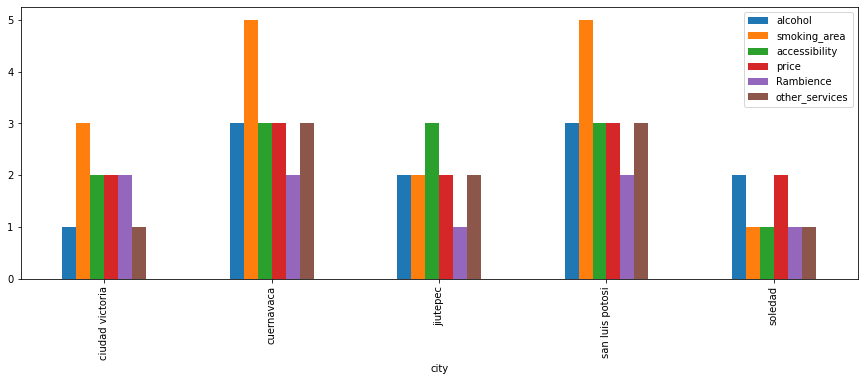

In [24]:
#plot for facilities provided by Restaurants based on city.
F8newplt=rgeo.groupby('city')['alcohol','smoking_area','accessibility','price','Rambience','other_services'].nunique().plot.bar(figsize=(15,5))

In [25]:
mapbox_access_token='pk.eyJ1IjoibmF2ZWVuOTIiLCJhIjoiY2pqbWlybTc2MTlmdjNwcGJ2NGt1dDFoOSJ9.z5Jt4XxKvu5voCJZBAenjQ'

In [26]:
mcd=rgeo[rgeo.country =='mexico']
mcd_lat = mcd.latitude
mcd_lon = mcd.longitude

data = [
    go.Scattermapbox(
        lat=mcd_lat,
        lon=mcd_lon,
        mode='markers',
        marker=dict(
            size=6,
            color='rgb(255, 0, 0)',
            opacity=0.4
        ))]
layout = go.Layout(
    title='Restaurants Locations',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=23,
            lon=-102
        ),
        pitch=2,
        zoom=4.5,
        style='dark'
    ),
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='restaurants')

In [27]:
#Step 1: Data loading
#We load User rating File 

ratings = pd.read_csv(path+'restaurant_ratings.csv')
ratings.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [28]:
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset
    
    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)] 
        val_pct : (int, float), validation set percentage 
        seed : seed value for RandomState
        
    Returns:
        list of indexes 
    """
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [29]:
#Step 2: Model training
#fastai function
#We’ll divide our data into train and validation set. 
#Our validation is 20% of our original dataset.
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4  #weight decay
n_factors=50   #dimension of embedding vector

In [30]:
#fastai function
from fastai.collab import *
dataframe = pd.read_csv('clean_data/restaurant_ratings.csv')
cf = CollabDataBunch.from_df(dataframe)
# cf = CollabFilterDataset.from_csv(path, 'rating_final.csv','userID','placeID','rating') #creating a custom data loader
#Parameters of the function:
#path: path to the location of the csv file
#rating_final.csv : name of the csv file.
#userID/placeID : column names of the 2 entities
#rating : column name of the dependent variable that you want to predic

#create a learner (model) and specify the batch size and optimizer 
#fastai function
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam,
                       tmp_name=tmp_path,models_name=models_path)
#Next step is to create a model object which is a function of the data object that we have created. 
#learner in fastai library is synonymous to model. 
#This function takes the following parameters:
#n_factors : Dimension of the embedding vector (50 in our case)
#val_idxs : Row Indices from the ratings.csv file which have to be considered in validation
#batch size : Number of rows that will be passed to the optimiser for each step of gradient descent. 
             #In our case 64 rows will be passed per iteration
#opt_fn : Optimiser that we want to use. In our case we are using Adam. 
        #You have access to different optimisers in this library


AttributeError: get_learner

In [ ]:
#training with learning rate as 1e-2 
learn.fit(1e-2,2,wds=wd, cycle_len=1,cycle_mult=2)
#The final step of training  is to actually train the model. 
#Calling fit on the learner object trains the model and learn the right values in the embedding and bias matrix.
#Parameters of the function:
#learning rate : 1e-2 is the learning rate that we use for optimisation
#wd : passing the weight decay
#cycle_len/cycle_mult : These are fastai goodies that incorporate the state of the art methods for learning rate scheduling.



In [ ]:
learn.sched.plot_lr()

In [ ]:
#You can observe training (left) and validation (right) loss after each epoch. 
#Our loss function for optimisation is MSE (Mean squared error) .



In [ ]:
preds = learn.predict() #prediction on validation
y=learn.data.val_y
math.sqrt(metrics.mean_squared_error(y,preds)) #calculating RMSE

In [ ]:
#We’ll use the trained model to predict on validation and compute RMSE.
#We get an RMSE of ~.90 which is at par with the current benchmarks for this dataset.
y=learn.data.val_y #actual ratings for validation
sns.jointplot(preds, y, kind='hex', stat_func=None); 


In [ ]:
#Prediction Rating(Y)  vs Actual Rating(x)

In [ ]:
#math.sqrt(0.521358)

In [ ]:
#learn.fit(1e-2,5,wds=wd, cycle_len=1,cycle_mult=2)

In [ ]:
#math.sqrt(0.5213228916299755)

In [ ]:

#rgeo = pd.read_csv(path+'geoplaces2.csv')
restaurant_names = rgeo.set_index('placeID')['name'].to_dict() ##creating dictionary of placeId: Place Name
g=ratings.groupby('placeID')['rating'].count() #counting the number of ratings for each place/Restaurant
topRestaurants = g.sort_values(ascending=False).index.values[:1000] #top 1000 places/Restaurants  based on number of ratings
topRestIdx = np.array([cf.item2idx[o] for o in topRestaurants])##id for the top place/Restaurant to link it to the embedding and bias matrix created by the model
#print(g)
#print("**")
#print(topRestaurants.shape)

In [ ]:
m=learn.model; m.cuda() #retrieving the model and shifting to gpu

In [ ]:
biasRestaurant = to_np(m.ib(V(topRestIdx))) #converting the torch embedding to numpy matrix

In [ ]:
#Bias can be considered as a proxy for how good/popular the place/Restaurant actually is
#Let’s see whether this is reflected in the bias from our model
biasRestaurant[:10]

In [ ]:

restaurant_ratings = [(b[0], restaurant_names[i] ) for i,b in zip(topRestaurants,biasRestaurant)]


In [ ]:
#worst places/Resturants based on bias ranking
sorted(restaurant_ratings, key=lambda o: o[0])[:10]

In [ ]:
#top places/Resturants based on bias ranking
sorted(restaurant_ratings, key=lambda o: o[0], reverse=True)[:10]


In [ ]:
restaurant_Embedding =to_np(m.i(V(topRestIdx)))
restaurant_Embedding.shape

In [ ]:
pca = PCA(n_components=3)
restaurant_PCA = pca.fit(restaurant_Embedding.T).components_

In [ ]:
restaurant_PCA.shape

In [ ]:
f1 = restaurant_PCA[0]
restaurantComponent1 = [(f,restaurant_names[i]) for f,i in zip(f1, topRestaurants)]

In [ ]:
sorted(restaurantComponent1, key=itemgetter(0), reverse=True)[:10]

In [ ]:
f2 = restaurant_PCA[1]
restaurantComponent2 = [(f,restaurant_names[i]) for f,i in zip(f2, topRestaurants)]

In [ ]:
sorted(restaurantComponent2, key=itemgetter(0), reverse=True)[:10]

In [ ]:
f3 = restaurant_PCA[2]
restaurantComponent3 = [(f,restaurant_names[i]) for f,i in zip(f3, topRestaurants)]

In [ ]:
sorted(restaurantComponent3, key=itemgetter(0), reverse=True)[:10]

In [ ]:
indexs = np.random.choice(len(topRestaurants), 20, replace=False)
X=f1[indexs]
Y=f1[indexs]
plt.figure(figsize=(25,25))
plt.scatter(X,Y)
for i, x, y in zip(topRestaurants[indexs], X, Y):
    plt.text(x,y,restaurant_names[i],color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [ ]:
indexs = np.random.choice(len(topRestaurants), 50, replace=False)
X=f1[indexs]
Y=f2[indexs]
plt.figure(figsize=(25,25))
plt.scatter(X,Y)
for i, x, y in zip(topRestaurants[indexs], X, Y):
    plt.text(x,y,restaurant_names[i],color=np.random.rand(3)*0.7, fontsize=11)
plt.show()